In [2]:
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import torch

# - Rockpool imports
from rockpool.parameters import Constant
from rockpool.timeseries import TSEvent
from rockpool.transform import quantize_methods as q
import rockpool.devices.xylo.syns61201 as xylo

import sys
sys.path.append("../training-pipeline/")
from lib.data_loading import load_data
from lib.xylo_net_adaptation import net_from_params, adapt_network

In [5]:
# Configuration
model_path = "trained_models/ff_deep_deep_res/best_model_63"

# Obtain training metadata
training_metadata = None
with open(f"{model_path}/training_metadata.json") as f:
    training_metadata = json.load(f)

# Load dataset
input_params = training_metadata["input_params"]
input_params["file_path"] = "../data/4bit_spikeset_PHASE_ts_sorted.npy"

train_dl, val_dl, test_dl = load_data(**input_params)

# Obtain neuron parameters
model_metadata = None
with open(f"{model_path}/model_metadata.json") as f:
    model_metadata = json.load(f)

neuron_parameters = {
    'tau_mem': model_metadata["params"]["tau_mem"],
    'tau_syn':  model_metadata["params"]["tau_syn"],
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': input_params["dt"],
}

# Build network from model parameters
model_params = None
with open(f"{model_path}/model_params") as f:
    model_params = json.load(f)

net = net_from_params(model_params, neuron_parameters)

print(f"Built network: \n\t{net}")

# Load network parameters
net.load(f"{model_path}/model_params")

#opt_params = None
#opt_params = torch.load(f"{model_path}/model_params", map_location=torch.device('cpu') )
#net.set_attributes(opt_params)

# Adapt network to be compatible with and deployable on Xylo
adapt_network(net,max_synapses=63)


Built network: 
	TorchSequential  with shape (12, 7) {
    LinearTorch '0_LinearTorch' with shape (12, 63)
    LIFTorch '1_LIFTorch' with shape (63, 63)
    TorchResidual '2_TorchResidual' with shape (63, 63) {
        LinearTorch '0_LinearTorch' with shape (63, 63)
        LIFTorch '1_LIFTorch' with shape (63, 63)
    }
    TorchResidual '3_TorchResidual' with shape (63, 63) {
        LinearTorch '0_LinearTorch' with shape (63, 63)
        LIFTorch '1_LIFTorch' with shape (63, 63)
    }
    LinearTorch '4_LinearTorch' with shape (63, 7)
    LIFTorch '5_LIFTorch' with shape (7, 7)
}


Final accuracy: 78.52%


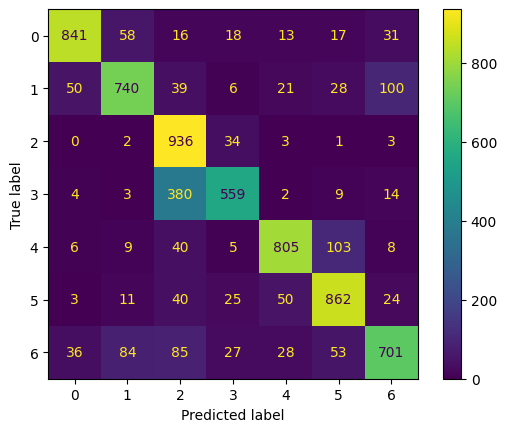

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       994
         1.0       0.82      0.75      0.78       984
         2.0       0.61      0.96      0.74       979
         3.0       0.83      0.58      0.68       971
         4.0       0.87      0.82      0.85       976
         5.0       0.80      0.85      0.83      1015
         6.0       0.80      0.69      0.74      1014

    accuracy                           0.79      6933
   macro avg       0.80      0.79      0.78      6933
weighted avg       0.80      0.79      0.78      6933



In [14]:
# Evaluate network on the full test set
net.eval()
ds = test_dl.dataset
with torch.no_grad():
    output, _, _ = net(ds.x)
    preds = output.sum(dim=1).argmax(dim=1)
    print(f"Final accuracy: {torch.round(torch.mean(preds == ds.y, dtype=float)*100,decimals=2)}%")

# Calculate confusion matrix
cm = confusion_matrix(ds.y, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(ds.y, preds))

Neural Activity (spikes per neuron): [ 4. 11.  2.  0. 16. 25. 12.]
Expected Label: 5
Predicted Label: 5


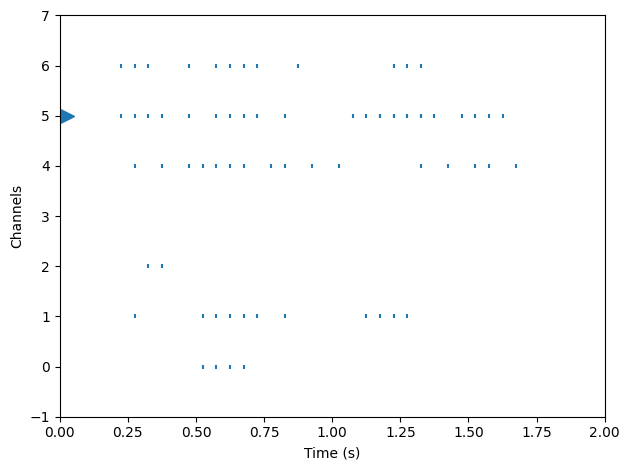

In [20]:
# Plot the network activity for a specific sample
net.eval()
ds = test_dl.dataset
i = 1
with torch.no_grad():
    output, _, b = net(ds.x[i])

    spks = torch.sum(output,dim=1)
    print(f"Neural Activity (spikes per neuron): {spks.numpy()[0]}")
    print(f"Expected Label: {int(ds.y[i])}")
    print(f"Predicted Label: {spks.argmax()}")

    TSEvent.from_raster(
                output[0].detach().numpy(),
                dt=5e-2,
            ).plot(marker="|", s=8)
    plt.plot(0, ds.y[i], '>', ms=20)
    plt.tight_layout()
    plt.show()

# Hardware Config Mapping

In [26]:
def drop_exceeding_synapses(spec):
    max_synapses = 63
    count = 0
    for neuron_id,neuron_weights in list(enumerate(spec["weights_rec"])):
        synapses_count = np.sum(neuron_weights != 0)
        if synapses_count > max_synapses:
            count_to_remove = synapses_count - max_synapses
            mask = rankdata(abs(neuron_weights),method='ordinal')-1 < count_to_remove + np.sum(neuron_weights == 0)
            spec["weights_rec"][neuron_id] = np.where(mask, np.zeros(len(neuron_weights)),neuron_weights).astype(int)        
            count += 1
    print(f"Dropped input synapses exceeding limits for {count} neurons")

In [23]:
# Convert network to spec
spec = xylo.mapper(net.as_graph())

# Fine tune the network weights prior quantization
# Global weights
spec["weights_in"] = (spec["weights_in"]*1)
spec["weights_rec"] = (spec["weights_rec"]*1)
spec["weights_out"] = (spec["weights_out"]*1)

# Per-Class weights
#spec["weights_out"][:,0] = (spec["weights_out"][:,0]*0.94)
#spec["weights_out"][:,1] = (spec["weights_out"][:,1]*0.95)
#spec["weights_out"][:,2] = (spec["weights_out"][:,2]*0.975)
#spec["weights_out"][:,3] = (spec["weights_out"][:,3]*0.97)
#spec["weights_out"][:,4] = (spec["weights_out"][:,4]*0.965)
#spec["weights_out"][:,5] = (spec["weights_out"][:,5]*0.99)
#spec["weights_out"][:,6] = (spec["weights_out"][:,6]*0.98)

# Quantise the parameters
spec_Q = copy.deepcopy(spec)
spec_Q.update(q.channel_quantize(**spec_Q))

# Drop synapses to make the network compatible with Xylo
#drop_exceeding_synapses(spec_Q)

# Convert spec to Xylo configuration
config, is_valid, m = xylo.config_from_specification(**spec_Q)
if not is_valid:
    print(m)
else:
    print("ok")

# Build XyloSim from the config
mod = xylo.XyloSim.from_config(config, dt = input_params["dt"])
print(mod)

ok
XyloSim  with shape (16, 1000, 8)


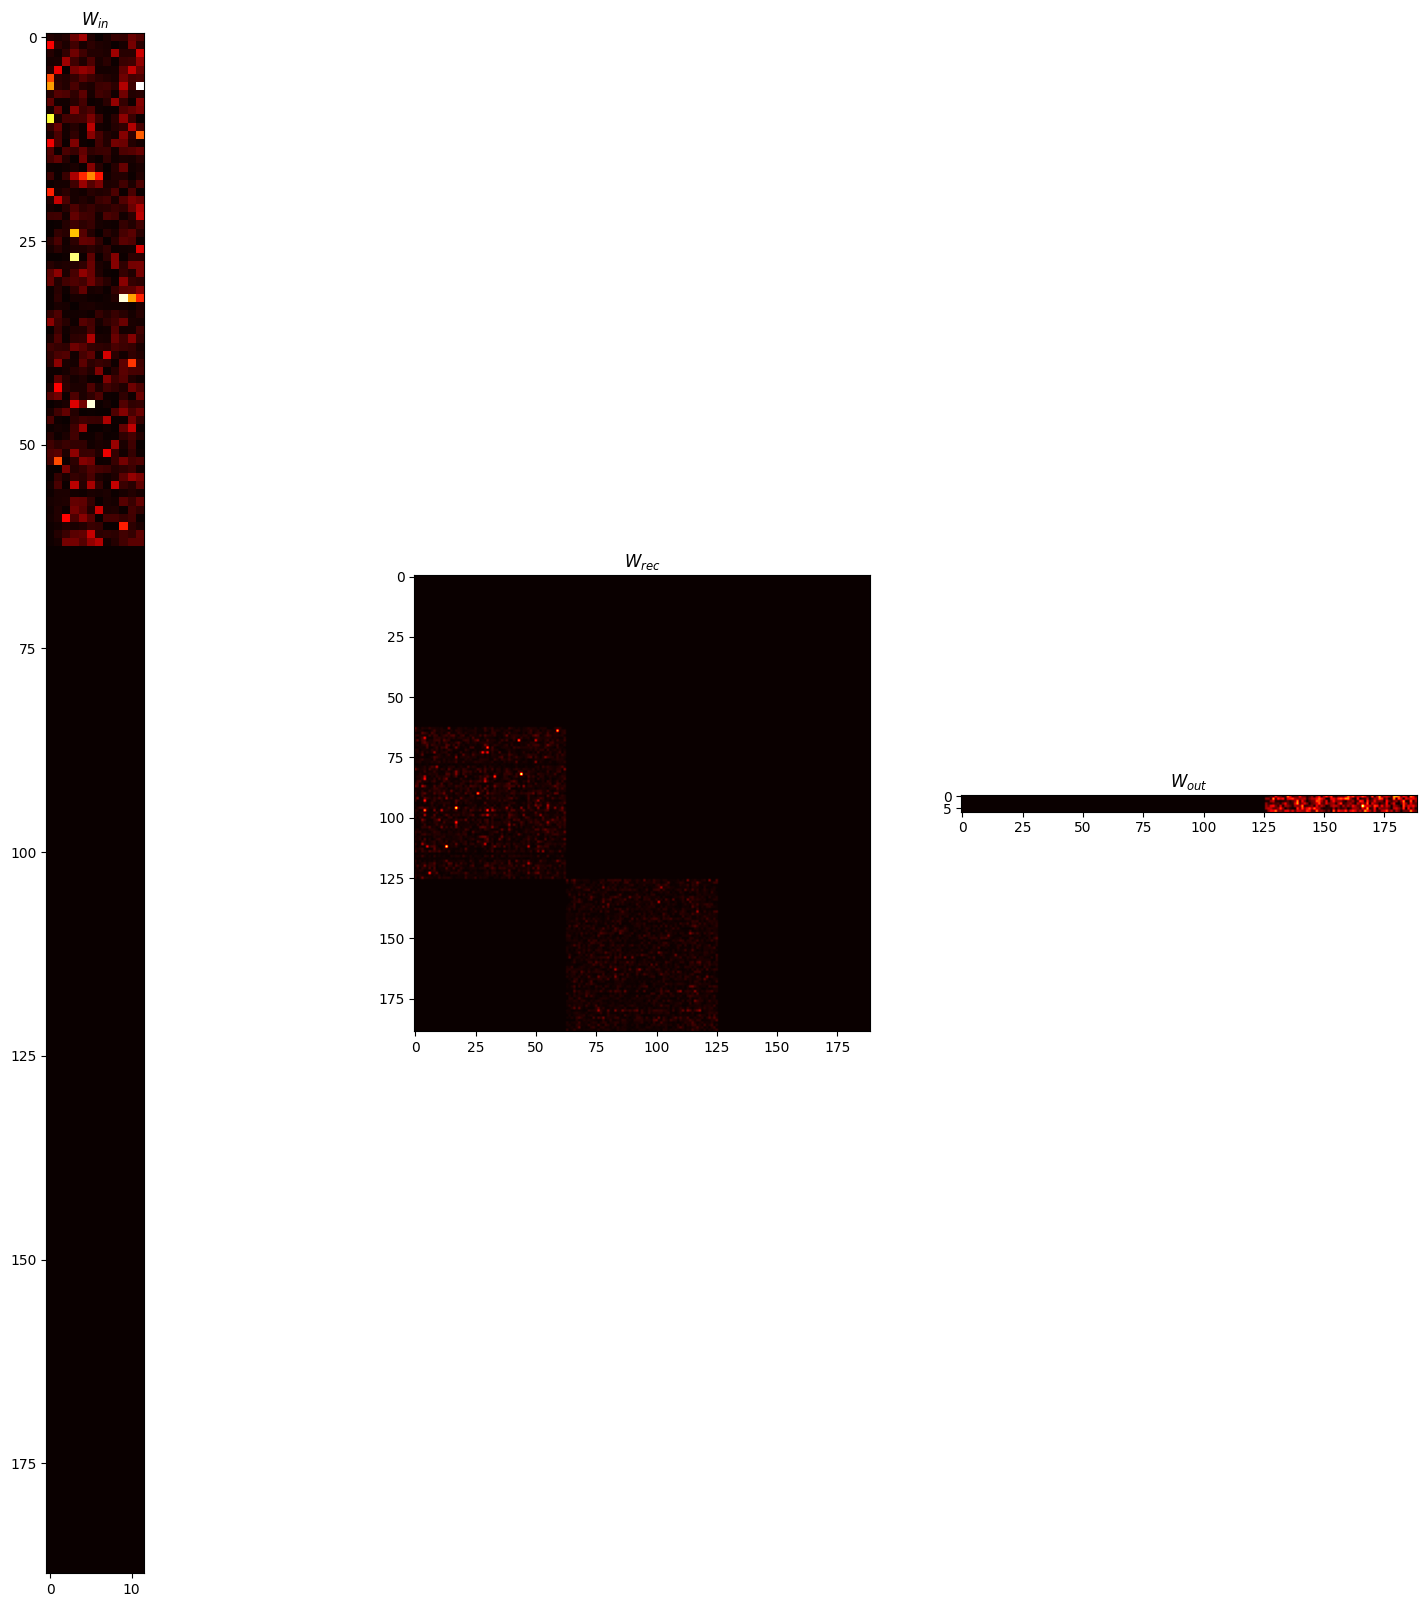

In [21]:
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(abs(spec['weights_in'].T), cmap="hot")
plt.title('$W_{in}$')

plt.subplot(1, 3, 2)
plt.imshow(abs(spec['weights_rec'].T), cmap="hot")
plt.title('$W_{rec}$')

plt.subplot(1, 3, 3)
plt.imshow(abs(spec['weights_out'].T), cmap="hot")
plt.title('$W_{out}$');



# Quantized Network Analysis

Final accuracy: 73.79%


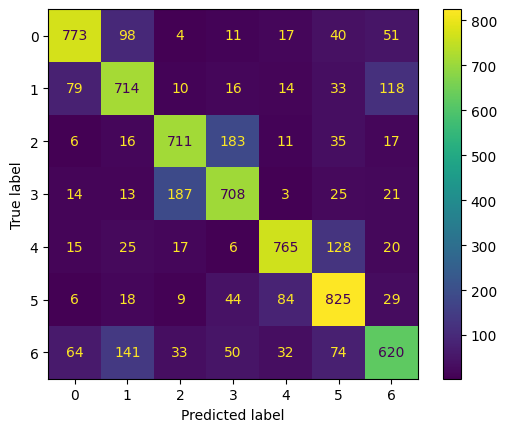

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       994
         1.0       0.70      0.73      0.71       984
         2.0       0.73      0.73      0.73       979
         3.0       0.70      0.73      0.71       971
         4.0       0.83      0.78      0.80       976
         5.0       0.71      0.81      0.76      1015
         6.0       0.71      0.61      0.66      1014

    accuracy                           0.74      6933
   macro avg       0.74      0.74      0.74      6933
weighted avg       0.74      0.74      0.74      6933



In [55]:
# Evaluate the XyloSim network on the full test set
ds = test_dl.dataset
preds = []
scores = []
for x,y in zip(ds.x,ds.y):
    output, _, rec = mod(x.numpy())
    pred = np.sum(output,axis=0)
    preds.append(np.argmax(pred))
    scores.append(np.argmax(pred) == y.numpy())

acc = np.sum(scores)/len(scores)

print(f"Final accuracy: {np.round(acc, decimals=4)*100}%")

# Calculate confusion matrix
cm = confusion_matrix(ds.y, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(ds.y, preds))

Readout layer activity (spikes): [ 5 15  2  1 11 23 13]
Label: 5
Prediction: 5


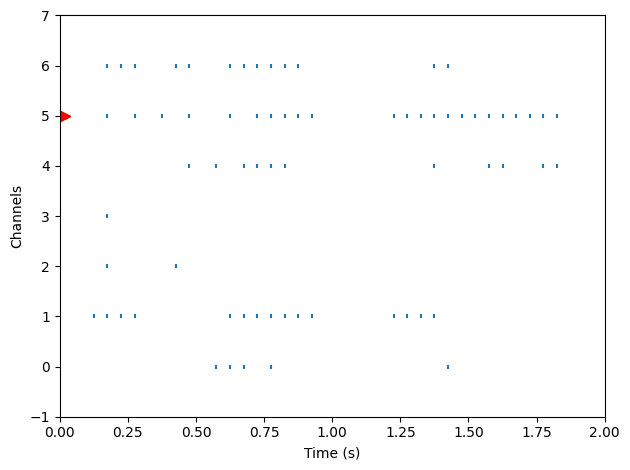

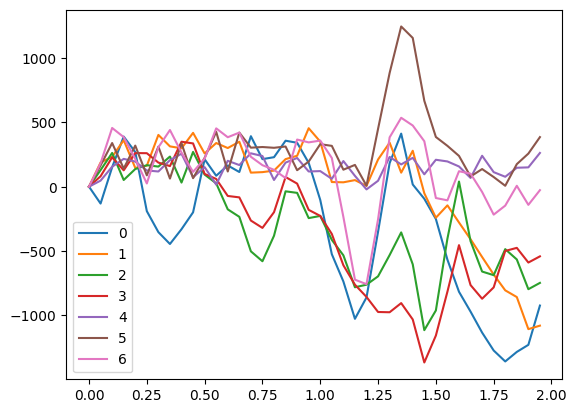

In [24]:
# Plot the XyloSim network activity for a specific sample
ds = test_dl.dataset
i = 1

output, _, rec = mod(ds.x[i].numpy(),record=True)

spks = np.sum(output,axis=0)
pred = np.argmax(spks)
print(f"Readout layer activity (spikes): {spks}")
print(f"Label: {int(ds.y[i])}")
print(f"Prediction: {pred}")

TSEvent.from_raster(
            output,
            dt=input_params["dt"],
        ).plot(marker="|", s=8)
plt.plot(0.01, ds.y[i], '>', ms=10, color='g')
plt.plot(0.01, pred, '>', ms=10, color='r')
plt.tight_layout()
plt.show()

times = np.arange(output.shape[0]) * input_params["dt"]
plt.plot(times, rec['Vmem_out'])
plt.legend(range(0,7))
plt.show()

# Xylo Hardware Deploy

In [18]:
import samna 
devices = samna.device.get_all_devices()

hdk = None
for device in devices:
    if device.device_type_name == "XyloImuTestBoard":
        hdk = samna.device.open_device(device)

if hdk == None:
    raise "No Xylo found"

mod_hdk = xylo.XyloSamna(hdk, config, input_params["dt"])


ValueError: Could not connect nodes! Source node id =  0. Destination node id =  0. Source output type = std::shared_ptr<const std::vector<std::variant<xyloImu::event::Spike, xyloImu::event::Readout, xyloImu::event::RegisterValue, xyloImu::event::MemoryValue, xyloImu::event::MembranePotential, xyloImu::event::SynapticCurrent, xyloImu::event::ReservoirSpike, xyloImu::event::Version, events::Error>>>. Destination input type = std::shared_ptr<const std::vector<std::variant<xylo::event::Spike, xylo::event::Readout, xylo::event::RegisterValue, xylo::event::MemoryValue, xylo::event::MembranePotential, xylo::event::SynapticCurrent, xylo::event::ReservoirSynapticCurrent2, xylo::event::ReservoirSpike, xylo::event::Version>>>.

